In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np
import time
from project_utilities import ValueSet, Loss, efficiency
from sklearn.model_selection import train_test_split


In [2]:
train_set_idx, val_set_idx=train_test_split(list(range(1,80)),test_size=24)
len(train_set_idx)

55

In [3]:
DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
DEVICE

'cuda:0'

In [5]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [6]:
random_seed= 123
NUM_EPOCHS=6
LEARNING_RATE=0.001
BATCH_SIZE=128

In [7]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)



Mounted at /content/gdrive/


In [8]:
%cd /content/gdrive/MyDrive/data

/content/gdrive/MyDrive/data


In [9]:
class MyDataset(torch.utils.data.Dataset): 
  def __init__(self, setID): 
        'Initialization' 
        npz_files_content = np.load("./Set_"+str(setID)+".npz")  
         
        self.X_set = torch.tensor(npz_files_content['X'])    
        self.y_set = torch.tensor(npz_files_content['y']) 
  def __len__(self): 
        'Denotes the total number of samples' 
        return len(self.y_set) 
  def __getitem__(self, index): 
        'Generates one sample of data' 
        # Select sample 
        X = self.X_set[index] 
        y = self.y_set[index] 
        return X, y

In [10]:
####################################################
##### Training and evaluation wrappers
###################################################
def train(model, num_epochs,
          learning_rate=0.01, seed=123, batch_size=128):
          
  
    # print(1)
    cost = []
    torch.manual_seed(seed)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    for e in range(1,num_epochs):
      # print(2)
      batch_num = 0
      for setID in train_set_idx:
          train_set = MyDataset(setID) # removed + 1
          train_generator = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True,drop_last=True)
          # print(setID)
          for X_train, y_train in train_generator:
            X_train=X_train.to(DEVICE)
            y_train=y_train.to(DEVICE)
            batch_num = batch_num + 1
            #### Compute outputs ####
            yhat = model(X_train)
            # print(3)
            loss = loss_model.forward(yhat, y_train)
            #### Reset gradients from previous iteration ####
            optimizer.zero_grad()
            #### Compute gradients ####
            loss.backward()
            #### Update weights ####
            optimizer.step()
            # print(4)
            #### Logging ####
            with torch.no_grad():
                yhat = model.forward(X_train)
                curr_loss = loss_model.forward(yhat, y_train)
                print('Epoch ID: %d ' % e, end="")
                print('  Set ID: %d' % setID, end="")
                print('  Batch ID: %d' % batch_num, end="")
                print(' | Loss: %.5f' % curr_loss)
                cost.append(curr_loss)
    return cost


In [11]:
class CNN1(torch.nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.features = torch.nn.Sequential(
        torch.nn.Conv2d(1, 2, kernel_size=3, padding="same"),
        torch.nn.Dropout2d(0.3),
        torch.nn.ReLU(inplace=True),
        torch.nn.BatchNorm2d(2),
        torch.nn.MaxPool2d(kernel_size=2),
        torch.nn.Conv2d(2,3, kernel_size=3, padding="same"),
        torch.nn.Dropout2d(0.3),
        torch.nn.ReLU(inplace=True),
        torch.nn.BatchNorm2d(3),
        torch.nn.MaxPool2d(kernel_size=2),
        torch.nn.Conv2d(3,4, kernel_size=3, padding="same"),
        torch.nn.ReLU(inplace=True),
        # torch.nn.Conv2d(4,4000, kernel_size=3, padding="same"),
        # torch.nn.ReLU(inplace=True),
        # torch.nn.BatchNorm2d(4),
        torch.nn.Flatten()
        )
  def forward(self, x):
    n, h, w = x.shape
    x = x.view(n, 1, h, w)
    x = self.features(x)
    return x


In [12]:
model = CNN1(4000)
model=model.to(DEVICE)
loss_model = Loss(0.00001)
cost = train(model,
             num_epochs=3,
             learning_rate=0.001,
             seed=123, batch_size=128)

Epoch ID: 1   Set ID: 28  Batch ID: 1 | Loss: 3.04598
Epoch ID: 1   Set ID: 28  Batch ID: 2 | Loss: 2.93161
Epoch ID: 1   Set ID: 28  Batch ID: 3 | Loss: 2.81470
Epoch ID: 1   Set ID: 28  Batch ID: 4 | Loss: 2.81009
Epoch ID: 1   Set ID: 28  Batch ID: 5 | Loss: 2.90173
Epoch ID: 1   Set ID: 28  Batch ID: 6 | Loss: 2.81660
Epoch ID: 1   Set ID: 28  Batch ID: 7 | Loss: 2.64553
Epoch ID: 1   Set ID: 28  Batch ID: 8 | Loss: 2.63182
Epoch ID: 1   Set ID: 28  Batch ID: 9 | Loss: 2.58952
Epoch ID: 1   Set ID: 28  Batch ID: 10 | Loss: 2.26383
Epoch ID: 1   Set ID: 28  Batch ID: 11 | Loss: 2.37991
Epoch ID: 1   Set ID: 28  Batch ID: 12 | Loss: 2.16067
Epoch ID: 1   Set ID: 28  Batch ID: 13 | Loss: 2.02782
Epoch ID: 1   Set ID: 28  Batch ID: 14 | Loss: 2.04747
Epoch ID: 1   Set ID: 28  Batch ID: 15 | Loss: 2.63031
Epoch ID: 1   Set ID: 28  Batch ID: 16 | Loss: 1.99081
Epoch ID: 1   Set ID: 28  Batch ID: 17 | Loss: 1.96584
Epoch ID: 1   Set ID: 28  Batch ID: 18 | Loss: 1.74703
Epoch ID: 1   Set I

In [13]:
def validate(model): 
  
    loss_val = [] 
    eff = ValueSet(0, 0, 0, 0) 
    # switch to evaluate mode 
    model.eval() 
    with torch.no_grad():
        for setID in val_set_idx: 
          val_set = MyDataset(setID+1) 
          val_generator = torch.utils.data.DataLoader(val_set,  
                                                      batch_size=5000,  
                                                      shuffle=True) 
          print(setID) 
          for X_val, y_val in val_generator: 
            X_val=X_val.to(DEVICE)
            y_val=y_val.to(DEVICE)
            # Forward pass 
            val_outputs = model(X_val) 
            loss_output = loss_model.forward(val_outputs, y_val) 
            loss_val.append(loss_output) 
            for label, output in zip(y_val.cpu().numpy(), val_outputs.cpu().numpy()):
                eff += efficiency(label, output, difference = 5.0,  
                                  threshold = 1e-2, integral_threshold = 0.2,  
                                  min_width = 3) 
    return sum(loss_val)/len(loss_val), eff.eff_rate, eff.fp_rate

In [14]:
loss_val, eff_rate, fp_rate = validate(model) 
print('Loss: %0.3f ' % loss_val, end="")
print('  Efficiency: %0.3f' % eff_rate, end="") 
print('  False positive rate: %0.3f' % fp_rate) 


13
25
64
12
17
35
18
65
57
26
52
19
32
9
4
68
69
24
30
11
22
23
48
37
Loss: 0.096   Efficiency: 0.000  False positive rate: 0.000


In [15]:
model.eval()

CNN1(
  (features): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Dropout2d(p=0.3, inplace=False)
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(2, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): Dropout2d(p=0.3, inplace=False)
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): ReLU(inplace=True)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
)

In [16]:

b=torch.tensor(cost)
cost1=b.cpu().numpy()
cost1[-1]

0.093340605

In [17]:
loss_test=loss_val.cpu().numpy()
loss_test

array(0.09576767, dtype=float32)

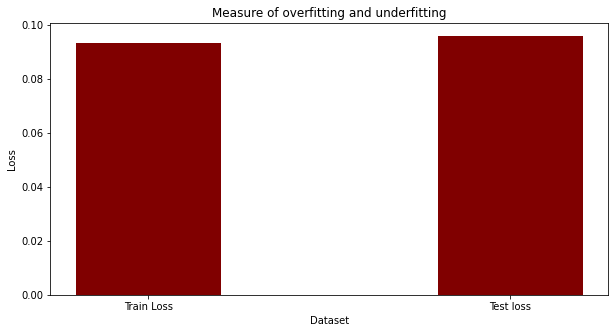

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

 
  
# creating the dataset
data = {'Train Loss':cost1[-1], 'Test loss':loss_test}
TrainTest = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(TrainTest, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Dataset")
plt.ylabel("Loss")
plt.title("Measure of overfitting and underfitting")
plt.show()

In [25]:
def train(model,train_set_idx, num_epochs,
          learning_rate=0.01, seed=123, batch_size=128):
    cost = []
    
    torch.manual_seed(seed)
    
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    
    for e in range(1,num_epochs):
      batch_num = 0
      for setID in train_set_idx:
          train_set = MyDataset(setID+1)
          train_generator = torch.utils.data.DataLoader(train_set, 
                                                        batch_size=batch_size, 
      shuffle=True)
          print(setID)
          for X_train, y_train in train_generator:
            X_train=X_train.to(DEVICE)
            y_train=y_train.to(DEVICE)
            batch_num = batch_num + 1
            #### Compute outputs ####
            yhat = model(X_train)
            loss = loss_model.forward(yhat, y_train)
            optimizer.zero_grad()
            
            #### Compute gradients ####
            loss.backward()
            
            #### Update weights ####
            optimizer.step()
            #### Logging ####
            with torch.no_grad():
                yhat = model.forward(X_train)
                curr_loss = loss_model.forward(yhat, y_train)
                cost.append(curr_loss)
    return cost

In [26]:
def validate(model,val_set_idx):
    loss_val = []
    eff = ValueSet(0, 0, 0, 0)
    # switch to evaluate mode
    model.eval()
    with torch.no_grad():
        for setID in val_set_idx:
          val_set = MyDataset(setID+1)
          val_generator = torch.utils.data.DataLoader(val_set, 
                                                      batch_size=1024, 
    shuffle=True)
          # print(setID)
          for X_val, y_val in val_generator:
            X_val=X_val.to(DEVICE)
            y_val=y_val.to(DEVICE)
            # Forward pass
            val_outputs = model(X_val)
            loss_output = loss_model.forward(val_outputs, y_val)
            loss_val.append(loss_output)
            for label, output in zip(y_val.cpu().numpy(), val_outputs.cpu().numpy()):
                eff += efficiency(label, output, difference = 5.0, 
                                  threshold = 1e-2, integral_threshold = 0.2, 
                                  min_width = 3)
    return sum(loss_val)/len(loss_val), eff.eff_rate, eff.fp_rate

In [27]:
a=[15,24,40,50]
train_cost=[]
test_cost=[]
for i in a:
  train_set_idx, val_set_idx=train_test_split(list(range(1,80)),test_size=i)
  torch.manual_seed(123)
  model = CNN1(4000)
  model=model.to(DEVICE)
  loss_model = Loss(0.00001)
  cost = train(model,train_set_idx,
             num_epochs=3,
             learning_rate=0.001,
             seed=123, batch_size=128)
  b=torch.tensor(cost)
  cost1=b.cpu().numpy()
  train_cost.append(cost1[-1])
  loss_val, eff_rate, fp_rate = validate(model,val_set_idx)
  loss_test=loss_val.cpu().numpy()
  loss_test
  test_cost.append(loss_test)

64
75
48
11
33
12
21
9
25
79
32
1
76
68
30
34
73
57
65
24
20
47
74
39
54
3
31
52
77
70
56
46
16
63
5
44
69
53
66
61
49
7
4
43
50
8
51
35
18
78
36
22
72
15
67
27
14
37
13
19
59
6
55
41
64
75
48
11
33
12
21
9
25
79
32
1
76
68
30
34
73
57
65
24
20
47
74
39
54
3
31
52
77
70
56
46
16
63
5
44
69
53
66
61
49
7
4
43
50
8
51
35
18
78
36
22
72
15
67
27
14
37
13
19
59
6
55
41
34
12
65
33
55
39
17
3
5
52
1
18
23
44
45
71
62
64
28
38
77
72
60
16
47
10
4
24
14
6
76
30
26
49
51
21
58
11
68
15
2
40
9
22
32
20
70
57
67
59
37
79
36
8
69
34
12
65
33
55
39
17
3
5
52
1
18
23
44
45
71
62
64
28
38
77
72
60
16
47
10
4
24
14
6
76
30
26
49
51
21
58
11
68
15
2
40
9
22
32
20
70
57
67
59
37
79
36
8
69
79
21
60
76
7
13
20
69
37
2
17
18
50
44
67
27
53
6
26
30
66
75
12
73
19
51
1
39
63
8
15
58
32
40
22
5
31
72
62
79
21
60
76
7
13
20
69
37
2
17
18
50
44
67
27
53
6
26
30
66
75
12
73
19
51
1
39
63
8
15
58
32
40
22
5
31
72
62
18
38
34
73
70
41
78
11
79
75
57
28
74
42
47
5
59
24
52
61
23
40
65
44
6
12
26
77
15
18
38
34
73

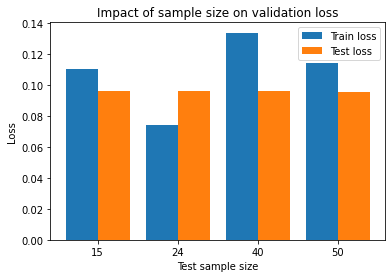

In [28]:
X = ['15','24','40','50']
f = train_cost
g = test_cost
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, f, 0.4, label = 'Train loss')
plt.bar(X_axis + 0.2, g, 0.4, label = 'Test loss')
  
plt.xticks(X_axis, X)
plt.xlabel("Test sample size")
plt.ylabel("Loss")
plt.title("Impact of sample size on validation loss")
plt.legend()
plt.show()